# Remote Sensing - Hyperspectral image analysis

October 13th 2020

Lab session - **Remote Sensing** class, **SICOM**, Grenoble INP-Phelma

Prof. Mauro Dalla Mura, Giuseppe Costantino

# 1. Introduction

The purpose of this lab session is to get familiar with some common techniques for the **analysis of remote sensing hyperspectral images**. We will analyze a hyperspectral image acquired on Washington DC Mall. More information on the data are available in the Appendix of this notebook.

Tip: use the Summary to move into the notebook, to collapse or show cells, etc.

# 1.1 Outline of the practical section

This notebook is divided into different parts composing a possible experimental analysis:



*   data visualization
*   exploratory analysis
*   dimensionality reduction
*   classification
*   exploitation of spatial features


# 1.2 Needed packages

This cells contains all the packages and functions that are needed for executing all the cells of this notebook. Please feel free to add new `import` statements to customize the code and to make new additional experiments. 

In [21]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils import imshow_stretch, gen_train_test, morph_prof
import seaborn as sns
import pandas as pd

# 1.3 [optional] Random seed setting

Throughout the notebook, we will use some randomness. You may want to fix the seed in input to the PRNG* in order to have reproducible results throughout several trials.



\* Pseudo-Random Number Generator: a deterministic algorithm for generating a pseudo-random sequence of numbers from a *seed*. By fixing the seed, you will obtain the same sequence **once restarted the algorithm**.


In [ ]:
np.random.seed(42)

# 1.4 Data loading and preparation

The variable `data` will contain the hyperspectral image.

Check the size of the image (num rows, num cols, num bands) by typing `data.shape`. The number of rows, columns and bands are stored in the variables `n_rows`, `n_columns` and `n_bands`, respectively.



In [3]:
data = scipy.io.loadmat('dcmall.mat')['data']
labels = scipy.io.loadmat('dcmall.mat')['test']
class_names = scipy.io.loadmat('dcmall.mat')['class_names']
class_colormap = scipy.io.loadmat('dcmall.mat')['class_colormap']

# images are reshaped in a vectorized fashion 

n_rows, n_columns, n_bands = data.shape
data_array = data.reshape((n_rows * n_columns, n_bands))
labels = labels.reshape((n_rows * n_columns, 1))  # ground truth for the classification

# classes from 1 to 7 are taken for classification
orig_labels=np.copy(labels)
valid_indices = labels != 0
labels = labels[valid_indices]

# 2. Data visualization

This part of the session is devoted to the visualization and inspection of the hyperspectral image Washington DC Mall.


* Visualize the image data
   * Look at one band of the image with the function `imshow_stretch` (e.g., if you want to see the 15th band
you should type: `imshow_stretch(data[:,:,14])` *
   * Open the file `wavelengths.txt`: it lists the correspondence between the band number
and the wavelenght

\* N.W.: this instruction should be followed by `plt.show()`.

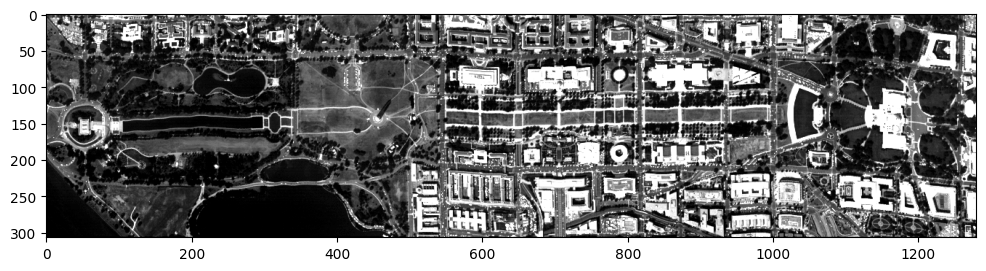

<Figure size 432x288 with 0 Axes>

In [22]:
_ = plt.figure(figsize=(12,8), dpi= 100)
imshow_stretch(np.flipud(data[:,:,14].T))  # rotated for better visualization
plt.set_cmap('gray')  # warning: permanent!
plt.show()
plt.set_cmap('viridis')  # restore the old colormap for future plots

# 2.1 Questions

![](./fig/Em_spect.jpeg)

* By looking at the figure above, identify the band number (approximately) corresponding to the wavelength of the red, green and blue color. Show a true color composition (R, G, B) of the hyperspectral image by typing: `imshow_stretch(data[:,:,(bR, bG, bB)])`.

* Select a band number corresponding to the wavelength in the Near Infrared (NIR) range of the spectrum. Show a false color composition (NIR, R, G) of the hyperspectral image.

* What can you assert by comparing the true and false color compositions?

* Perform an interpretation of the image by looking at the color representations.
   * Which thematic classes can you determine?
   * Which different land cover classes can be determined thanks to the **spectral** and which thanks to the **spatial** resolution of the image?
* By looking at the image, can you guess if the the image was spatially corrected? (*Note that the image was acquired by an airplane. Typically in this scenario the main source of spatial distortions is due to the movement of the platform.*)



In [ ]:
# TODO --> use this cell or add new cells below

# 3. Exploratory analysis

In this part you will be asked to perform some simple data inspections in order to gain more insights about it.



# 3.1 Band inspection and analysis

1. Look at the different bands. You can visualize a single band *b* by typing: `imshow_stretch(data[:,:,b])`.
   * What can you state? Are the bands significantly different one to the other? Are they “equally informative”?

![atmwin](./fig/atmoswindows1.png)

2. Take a look at the figure above.
   * Can you see any correspondence between the spectrum of the atmospheric absorption and how the data looks like at the different wavelengths?

In [ ]:
# TODO --> use this cell or add new cells below

# 3.2 Inspection of the spectral signatures of some materials

Show a single band or a RGB composite of the image. You are encouraged to create a new figure by typing `plt.figure()` and to play with its input parameters `figsize` and `dpi` for having a larger (smaller) image and a higher (lower) resolution, respectively.

Move the cursor on the image. The top left corner is `(0, 0)` and the bottom right corner is `(n_rows, n_columns)`.
* Note down the image coordinates of some pixels belonging to different land cover types.
* Plot the spectral signature of the selected pixels. For example:

```
plt.plot(data[row_1, col_1, :], 'b', label='pixel 1')
plt.plot(data[row_2, col_2, :], 'g', label='pixel 1')
# ...
plt.legend()
plt.show()
```
* Briefly describe how these patterns look like in the feature space.
* Question Which bands/ranges of bands are more important for discrimination?


In [ ]:
# TODO --> use this cell or add new cells below

# 3.3 Analysis of band correlation

In order to check the correlation among bands, we look at the correlation matrix of the data, which shows the cross-correlation between pairs of bands. We have already provided you with the code for its calculation and display. The colorbar at the right side shows the correlation $\rho$. Small values denote low correlation, while large values high correlation.

* Describe how the correlation matrix looks like and make some remarks about it.

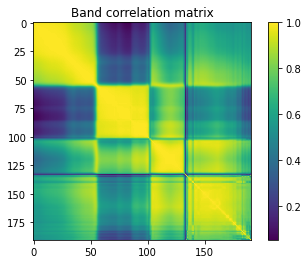

In [ ]:
Cm = np.corrcoef(data_array[range(0,data_array.shape[0],100),:], rowvar=False)
plt.imshow(Cm)
plt.colorbar()
plt.title('Band correlation matrix')
plt.show()

# 3.4 Data dynamics

Check the dynamic of the data by looking at the standard deviation of each band. We have already provided you with the code for its calculation and display.

* Which bands are the most “informative”? (For example, you can show a band with high and one with low standard deviation and compare them)
* What can you assert by looking at this plot?

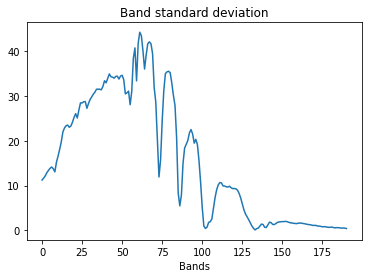

In [ ]:
sigma = np.std(data_array, axis=0)
plt.figure()
plt.plot(sigma)
plt.xlabel('Bands')
plt.title('Band standard deviation')
plt.show()


# 4. Dimensionality reduction

In this part, you are asked to analyze how a reduction of the data dimensions (initially, there are 191 bands) can still retain most of the information linked to the data variability and under which conditions this may be possible.

You will make a Principal Component Analysis (PCA). Roughly speaking, the PCA is a linear transformation which reprojects the data in another space which axes are the direction of **maximum variability**. Therefore, the **intuition** behind this is that the transformation will retain the main variability (information) of the data.

In addition, given $N$ the dimensionality of the data, it is possible to select the first $ k \ll N$ *principal components* (which correspond to the eigenvectors associated to the $k$ largest eigenvalues of the covariance matrix of the data) for obtaining a representation of the data which retains as much variability as possible.

We have already provided you with the code for its calculation, but please take a little bit of time to analyze it and understand how the PCA works.

N.W.: this version of the PCA code is far unefficient with respect to ones that you can find in standard statistical libraries. In fact, the calculation of the covariance matrix become harder and harder as the dimensionality increases. Efficient methods overcome this calculation by recalling some properties which link the data to the eigenvalues and eigenvectors of the covariance matrix.

In [ ]:
Sigma = np.cov(data_array, rowvar=False)  # covariance matrix
[U, S, V] = np.linalg.svd(Sigma)  # U: eigenvectors of Sigma, S: eigenvalues of Sigma
D = data_array - np.mean(data_array, axis=0)  # center the data: rigid rotation

Dp = np.dot(data_array, U)  # linear transformation

Inspect the eigenvalues (e.g., `plot(S[:k])` for the first *k* eigenvalues). You will find out that the eigenvalues are sorted by decreasing value (the same sorting goes for the eigenvectors `U`). You can show that the sum of the eigenvalues is equal to the trace of the covariance matrix, that is the total variance (**variance preservation**).

* Each eigenvalue accounts for a certain fraction of explained variance of the original data. Inspect which is that fraction of variance associated to the data

* About how many components do you think are relevant for a good approximation of the data? Why?

In [ ]:
# TODO --> use this cell or add new cells below

Show the principal components. In order to show them you need to reorganize the data in matrix format (e.g., `PC1 = Dp[:, 0].reshape((n_rows, n_columns))` for the first PC).

In [ ]:
# TODO --> use this cell or add new cells below

* Do the components corresponding to the smallest eigenvalues show only noise?
* **[optional]** Why? (Hint: compute the covariance of the transformed data by tiping `Cp = np.cov(Dp, rowvar=False)` and set very low values to zero
`Cp[np.abs(Cp) < 1e-10] = 0`. You should find out that the matrix is diagonal. What does it mean? What does it imply?)

In [ ]:
# TODO --> use this cell or add new cells below

# 5. Hyperspectral classification

This part is devoted to perform a classification of the data. In particular, by relying on the spectral information of the bands, we want to set a "supervised" learning task: we will have a **training set** consisting of pixels and labels, where each label is going to describe the material of that pixel. The **goal** will be to train a classifier by using `<pixel, label>` pairs, such that it learns how to classify the material of a pixel by relying on its spectral features. The classifier will be then tested on a test set for assessing its performance.

# 5.1 Training and test set creation

We will take 40 randomly chosen samples from the labeled set for each class in order to perform the training. The remaining samples will be used for the test. For creating the two sets run the following cell.

In [6]:

classes = np.unique(labels)
n_classes = classes.shape[0]

n_samples_per_class = 40

tr_idx, ts_idx = gen_train_test(orig_labels, labels, classes, n_samples_per_class)

X_train, y_train = data_array[tr_idx].astype('double'), orig_labels[tr_idx].ravel()
X_test, y_test = data_array[ts_idx].astype('double'), orig_labels[ts_idx].ravel()

# 5.2 Support Vector Machine (SVM) classification

You will perform the training of the SVM on the training set and run the inference (classification) on the whole data, while you will evaluate the performance only on the test data.

The **intuition** behind the Support Vector Machine is the so-called "maximum margin classification". Imagine a problem with two well-separable classes in a 2D feature space. A linear SVM will classify the samples by drawing a straight line for separating the two classes, such that it will maximize the distance from the nearest points of the two classes, as shown in the figure below.

![svm](https://nlp.stanford.edu/IR-book/html/htmledition/img1260.png)

In more complex setting, SVM use a "soft margin" when the classes are not perfectly separable and will use the *Kernel trick* for drawing nonlinear decision shapes.

![svm-soft](https://www.researchgate.net/profile/Pierre_Louis_Frison/publication/224713410/figure/fig1/AS:382573722259457@1468224091559/SVM-classifier-scheme-a-Linear-and-b-nonlinear-cases.png)

In this notebook, the SVM you will use will have a Radial Basis Function (RBF) Kernel (or Gaussian kernel), whose mathematical formulation is the following:

$K(\mathbf{x}, \mathbf{y}) = exp(
  \frac {\lVert \mathbf{x} - \mathbf{y} \rVert ^ 2} {2\sigma^2}
)$, where often $\gamma = \frac{1}{2\sigma^2}$.

The $\gamma$ parameter controls the shape of the nonlinear decision boundary. Small values of gamma will correspond to smoother shapes around the support vectors (large standard deviation), while larger values of gamma will let the decision boundary to follow more and more the support vectors (small standard deviation) with the risk of overfitting the data.

Conversely, the $C$ parameter of SVM will (inversely) control the amount of regularization of the model. Large values of C will make the margin to be hard, with little or no flexibility for misclassified samples, while smaller values of C will let the margin to be soft and relax the maximal margin condition in the optimization function.

In this case, you will have these two free parameters to adjust for the classification in the second part of the exercise.

In addition, the data are scaled in order to better condition the underlying optimization problem.

N.W.: do not forget to scale (or inverse-scale) the data for avoiding inconsistent results!

In [7]:
# data scaling: they will have zero mean and unit standard deviation
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

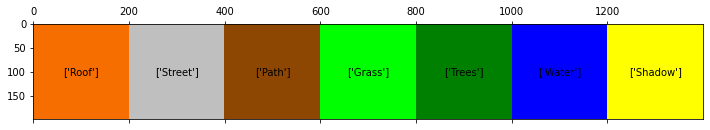

In [8]:
# useful colormap tools for displaying the classification results
colors = [class_colormap[i] for i in range(len(class_colormap))]
cmap = matplotlib.colors.ListedColormap(colors, name='colors', N=None)

# reminder of the class colors
fig, ax = plt.subplots(figsize=(12,8))
color_matrix = np.zeros((200, 200 * n_classes))
for i in range(n_classes):
  color_matrix[:, i * 200 : (i + 1) * 1200] = i + 1

ax.matshow(color_matrix, cmap=cmap)
for i in range(n_classes):
  ax.text(100 + 200 * i, 100, class_names.ravel()[i], va='center', ha='center')
plt.show()

We can thus instantiate a Support Vector Classifier (SVC) object and train it with the training data (fit).

We choose for you $C=100$ and $\gamma$ inversely proportional to the dimensionality of the data (use the keyword parameter `gamma='auto'`). There are pretty interesting motivations behind the tuning of the $\gamma$ parameter, but they go beyond the scope of the exercise and therefore will not be addressed.

N.W.: for this section, do not forget to change the value of $\gamma$ according to the dimensionality of the data (e.g., if you are classifying by using only 5 bands, therefore the value of $\gamma$ should be 1/5).

In [9]:
# Classification with SVM

svm = SVC(kernel='rbf', C=100, gamma=1/data_array.shape[1])

svm.fit(X_train, y_train)


SVC(C=100, gamma=0.005235602094240838)

Once fitted, the model can be used in inference mode, that is it can be used for classifying new pixels. We use it first for classifying the whole image. Then we use it for evaluating the test pixels and on that set of samples we compute also the Overall Accuracy, which represents the fraction of well classified samples.

In [10]:
# Inference and accuracy calculation
pred = svm.predict(scaler.transform(data_array))  # classification of the total image
acc = svm.score(X_test, y_test)  # TEST mean accuracy (n. correctly classified test samples / total n. test samples)
print('Mean TEST Overall Accuracy (OA):', acc)

Mean TEST Overall Accuracy (OA): 0.9834594178740864


We can display the classification result.

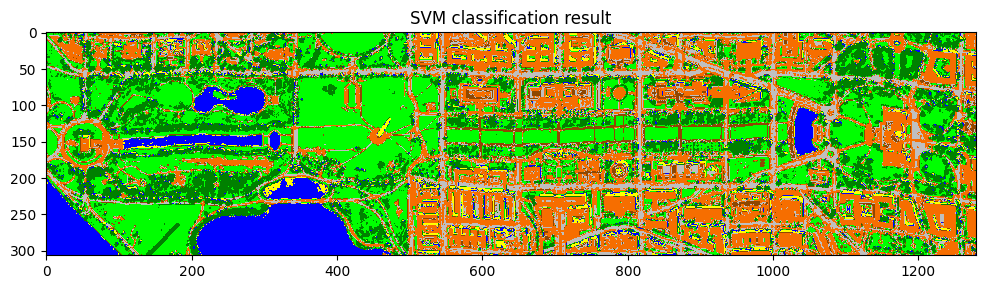

In [20]:
# Classification result visualization
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(np.flipud(pred.reshape(n_rows, n_columns).T), cmap=cmap)  # rotated for better visualization
plt.title('SVM classification result')
plt.show()

# 5.3 Performance assessment

If we only analyze the overall accuracy (OA) and we only look at the classified image, we could achieve misleading results, even if the image looks fine "by eye" and the OA is close to 100%, as in this case.

A useful tool for inspecting the complete classification result is the **Confusion Matrix**. The generic element $C_{i,j}$ of this matrix represents the number of samples that is known to belong to class $i$ and has been predicted as belonging to class $j$. We can now note that the overall accuracy is, in fact, the sum of the element on the diagonal of the confusion matrix. The out-of-diagonal elements are all those misclassified samples which were assigned to a class $j$ but belonged to class $i$ or vice-versa (see the examples in the cells below for better understand).

* **[optional]** In which cases the overall accuracy would lead to misleading results? Can you provide a concrete example?

\
\
From the confusion matrix we can define further indexes, which are general concepts but we'll particularize them to our case.

1. Producer's accuracy (recall): defined as the fraction of true positives over the sum of true positive and false negatives: $R = \frac{TP}{TP + FN}$. It describes the "omission errors", that is all the cases in which the classifier has **failed to apply the correct label**.
2. User's accuracy (precision): defined as the fraction of true positives over the sum of true positives and false positives: $P = \frac{TP}{TP + FP}$. It describes the "commission errors", that is all the cases in which the classifier **applies the wrong label**.

The recall is also called "sensitivity": it measures the fraction of **positives which are correctly identified**.
The precision is also called "specificity": it measures the fraction of **negatives which are correctly identified**.

An example of interpretation of these two indexes is provided just below.

In a real scenario, both of these two indexes cannot be both high at the same time, although it is ideally what we would like.

\
Both these two indicators are complementary to the overall accuracy. Their harmonic mean is called F1-score (or F-score) $F = \frac{2}{\frac{1}{R} + \frac{1}{P}}$ and constitutes a more robust index for the assessment of classification results.




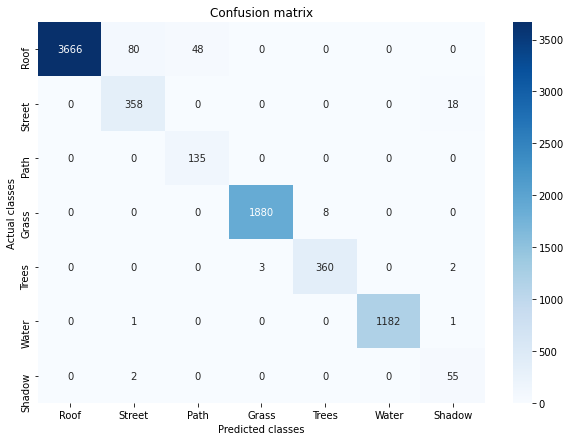

In [ ]:
# Confusion matrix analysis
cl = ['Roof', 'Street', 'Path', 'Grass', 'Trees', 'Water', 'Shadow']
y_predicted = svm.predict(X_test)
cm =confusion_matrix(y_test, y_predicted)

df_cm = pd.DataFrame(cm, index = [i for i in cl],
                  columns = [i for i in cl])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.title('Confusion matrix')
plt.show()


In [ ]:
# further indices
p = precision_score(y_test, y_predicted, average=None)
r = recall_score(y_test, y_predicted, average=None)
fs = f1_score(y_test, y_predicted, average=None)
print("Recalls:", r)
print("Precisions:", p)
print("F1-Scores:", fs)

Recalls: [0.96626252 0.95212766 1.         0.99576271 0.98630137 0.99831081
 0.96491228]
Precisions: [1.         0.81179138 0.73770492 0.9984068  0.97826087 1.
 0.72368421]
F1-Scores: [0.98284182 0.87637699 0.8490566  0.997083   0.98226467 0.99915469
 0.82706767]


Let's take the class 1 (Roof) as an example. The recall is a measure of the model's ability to correctly classify the positive samples. By looking at the confusion matrix, we can look at the first row, in correspondence of the samples that we *know* they belong to class 1. In fact, 42 of that samples were classified as Street and 26 as Path. Therefore we have $42 + 26$ false negatives, that is samples which belong to Roof class but which were erroneously classified. This means that $R_{Roof} = \frac{3726}{3726 + 42 + 26} = 0.98$.

Conversely, if we look at the Path class, we know that 134 samples were correctly classified, but if we look at its column, we see that 26 samples have been classified as Path but they belonged to the Roof class. Therefore, this 26 samples are false positives, that is samples that have been classified as correct but they were not. This means that $P_{Path} = \frac{134}{134+26}=0.83$.

# 5.4 Further analyses

Perform the same procedures but considering only
1. a single band (arbitrarily chosen)
2. the three bands used for the
true color composition and
3. the three bands chosen for the false color composition.

Comment the results.
* How the change in the bands affect the results? Why?
* Are you able to detect and comment which are the differences in the predictions between the different procedures?
* By looking at the confusion matrix and the indices, which conclusion can you draw? Which do you expect from it?

\
Look again at the plot of the standard deviation of the bands. Perform a classification excluding ranges of bands with low (high) standard deviation.
* What do you expect will happen to the classification accuracy?
* The results agree with your expectations?

\
**[Optional]** Perform now a classification by using the data on which you applied PCA.
* How many principal components would you choose? Why? (Hint: look at the wavelengths of the sensor. Do the majority of the bands cover a common part of the spectrum? If yes, what can we conclude from that? What could be a possible strategy?)

**[Optional]** Perform some of the tests already done considering a different number of training samples (change the second input parameter of gen_train_test).
* What do you expect will happen? Comment briefly and compare it with the actual results.

**[Optional]** Perform further test by changing:
  * the value of the penalization $C$
  * the value of $\gamma$
  * the kernel (you can either instantiate the object `LinearSVC` or using `SVC` adding the keyword parameter `kearnel='linear'`).

  How the change in these parameters affect the classification? Comment the results.

In [ ]:
# TODO --> use this cell or add new cells below

# 6. Spatial$-$Spectral classification

Till now the classification performed on the data was only relying on the spectral characteristics of the pixels. No exploitation of the spatial arrangement of the pixels was done. In order to take this complementary source of information into account, we can consider “spatial features”: features that model the spatial information (e.g., spatial correlation of **neighboring** pixels, **geometrical** characteristics of the objects, etc). Once computed, these features can be considered by a classifier.
There are many ways to extract spatial features. In this lab session we will consider the features derived by an Extended Morphological Profile (EMP) (see the paper `ClassificationEMP.pdf` in the doc folder for more information). The EMP is composed by a concatenation of Morphological Profiles (MPs). An MP is a sequence of opening and closing by reconstruction with a structuring element of fixed shape and increasing size and can be considered as a multiscale representation of the image. A representation is given in the image below.

![](./fig/MP.png)

The EMP is obtained by concatenating different MPs each one computed on one of the first Principal Components of the image (see figure below).

![](./fig/EMP.png)

The MP is implemented by the function `morph_prof` in the file `utils.py`.

The EMP is obtained by considering the first principal components of the image. The example below shows how to build an EMP considering the first 3 PCs, with MPs computed with circular structuring elements with initial radius 1, increment step size of 3 and 4 levels (thus, leading to an MP of 9 = 4 closings + original image + 4 opening)

* Have a look to the spatial features in the EMP and make some remarks.

In [ ]:
EMP = np.zeros((n_rows, n_columns, 27))
for i in range(3):
    MP = morph_prof(Dp[:,i].reshape(n_rows, n_columns), 1, 3, 4)
    EMP[:,:,9 * i : 9 * (i + 1)] = MP

# TO DO --> visualize the EMP and give some comments

Perform a classification considering the EMP. Note that the EMP, after its computation, is a stack of images. Thus, it should be converted in vector format for obtaining a vector whose shape is `(n_rows * n_columns`, `num levels of EMP)`.

* Comment the results. What do you expect? Does the classifier exploit the spatial features? This let the model achieve better performances? Comment all this aspects. Are there any areas in the image in which you clearly see a better classification? Do you figure out why?

* **[Optional]** Perform a classification of each MP. Change the settings of the MP (size of the SE, number of levels) and see the changes in the classification.

* **[Optional]** Perform a classification concatenating the EMP and the original image.

In [ ]:
# TODO --> use this cell or add new cells below

# Appendix $-$ data

The hyperspectral image of Washington DC mall will be used in this lab section (Figure 5) . The image was acquired by the airborne mounted Hyperspectral Digital Imagery Collection Experiment (HYDICE) sensor over the the Mall in Washington, DC. The image comes along with MultiSpec (a freeware multispectral image data analysis system developed at Purdue Uni- versity) and is available at https://engineering.purdue.edu/~biehl/MultiSpec/hyperspectral.html. It is provided with the permission of Spectral Information Technology Application Center of Virginia who was responsible for its collection. The sensor system used in this case measured pixel response in 210 bands in the 0.4 to 2.4 μm region of the visible and infrared spectrum. Bands in the 0.9 and 1.4 μm region where the atmosphere is opaque have been omitted from the data set, leaving 191 bands. The data set contains 1208 scan lines with 307 pixels in each scan line with a spatial resolution of about 2.8 m. Seven thematic land cover classes are present in the scene: Roofs, Street, Path (graveled paths down the mall center), Grass, Trees, Water, and Shadow.

Below the Washington DC Mall data set is shown (false color composite).

![dc](fig/dc.pdf)